# Part I: Producing a dataset

Authors: Jordi Bolibar & Facundo Sapienza


This notebook is dedicated to obtaining all necessary data to train the machine learning models of this project. For that, we need climate, topographical and mass balance data for all glaciers in Scandinavia. The retrieval of the climate and topographic data is processed using the [Open Global Glacier Model](https://oggm.org). 
First, we import the dependencies and we configure OGGM. 

```{note}
Before running this notebook, be sure you Jupyter kernel (top left corner of the notebook) has been configure to work with the `MB_Finse` conda environment.
```

In [1]:
import oggm
oggm.__version__

'1.6.0'

We import all the necessary dependencies to retrieve the data with OGGM and to postprocess it. We use multiprocessing with OGGM to make things faster.

In [2]:
import xarray as xr
import numpy as np
import rioxarray
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm import entity_task, global_tasks
from oggm.utils import compile_climate_input
from oggm.core import gis
from oggm.utils import DEM_SOURCES
from pathlib import Path
import os
import logging
from datetime import datetime, timedelta

pd.set_option('display.max_columns',None)

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True 
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2023-04-16 13:47:02: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-04-16 13:47:02: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-04-16 13:47:02: oggm.cfg: Multiprocessing: using all available processors (N=4)
2023-04-16 13:47:02: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2023-04-16 13:47:02: oggm.cfg: Multiprocessing switched ON after user settings.


Choose your OGGM path where you want to store all the data. Since we are all working in the same JupyterHub, we can store the information in the same shared folder. 

In [3]:
parent_path = os.path.dirname(Path().resolve())
workspace_path = os.path.join(parent_path, 'OGGM_data_Finse')
#workspace_path = '/home/jovyan/shared/glacier-ml-2022/Mass_Balance_ML_Modelling/Data'

if not os.path.exists(workspace_path):
    os.mkdir(workspace_path)
else:
    cfg.PATHS['working_dir'] = workspace_path

Entity tasks are custom functions that can be run in OGGM to perform specific tasks. OGGM is centered around `gdir`s, which are Glacier Directories. These are Python classes representing glaciers individually, containing all the necessary information for their simulation. Here, we declare all the custom entity tasks (which will be used later on), since they need to be declared before initializing the glacier directories. This one is used to get all the topographic data for all gdirs. 

In [4]:
@entity_task(log)
def get_topo_predictors(gdir):
    """Mandatory docstring
    """
        
    training_data = {'zmed': 0.0,
                 'zmax': 0.0,
                 'zmin': 0.0,
                 'area': 0.0,
                 'slope': 0.0,
                 'lat': 0.0,
                 'lon': 0.0,
                 'icecap': 0.0,
                 'ID': ""
        }
    
    gl_shp = gdir.read_shapefile('outlines')
    
    training_data['zmed'] = float(gl_shp.Zmed.values[0])
    training_data['zmax'] = float(gl_shp.Zmax.values[0])
    training_data['zmin'] = float(gl_shp.Zmin.values[0])
    training_data['area'] = gdir.rgi_area_km2
    training_data['lat'] = gdir.cenlat
    training_data['lon'] = gdir.cenlon
    training_data['icecap'] = int(gdir.is_icecap)
    training_data['slope'] = float(gl_shp.Slope.values[0])
    training_data['ID'] = gdir.rgi_id
        
    return training_data

Download all data from glaciers in Scandinavia (RGI region '08') using the Randolph Glacier Inventory (RGI v6). This might fail if data has already been downloaded (even partially). This is done by initializing the glacier directories. 

In [5]:
rgi_region = '08' # Scandinavia
rgi_version = '6'
rgi_dir = utils.get_rgi_dir(version=rgi_version)
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/'
gdirs = workflow.init_glacier_directories(rgidf, from_prepro_level=3, prepro_base_url=base_url, prepro_border=10)

2023-04-16 13:47:44: oggm.workflow: init_glacier_directories from prepro level 3 on 3417 glaciers.
2023-04-16 13:47:44: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3417 glaciers
/home/jovyan/envs/oggm_env/lib/python3.11/site-packages/oggm/utils/_workflow.py:2828: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.round(float(_area), decimals=3)
/home/jovyan/envs/oggm_env/lib/python3.11/site-packages/oggm/utils/_workflow.py:2828: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.round(float(_area), decimals=3)
/home/jovyan/envs/oggm_env/lib/python3.11/site-packages/oggm/utils/_workflow.py:2828: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.round(float(_area), d

## 1.1. Get geodetic glacier mass balance data

In order to train our machine learning models, we need target data, in this case geodetic mass balance. For that, we get the geodetic MB for all glaciers in Scandinavia from [Hugonnet et al. (2021)](https://www.nature.com/articles/s41586-021-03436-z). The [OGGM Shop](https://docs.oggm.org/en/stable/shop.html) allows us to easily have access to a wide range of interesting datasets. 

In [6]:
mb_df = utils.get_geodetic_mb_dataframe()
mb_df.drop(columns=['area', 'reg', 'is_cor'])
mb_df.index.names = ['rgi_id']
mb_df = mb_df.reset_index()

# We want to filer just the right region #def extract_region_id(name):
mb_df['region'] = mb_df.apply(lambda row: row.rgi_id.split('-')[1][:2], axis=1)
mb_df = mb_df[mb_df.region==rgi_region]
mb_df

,rgi_id,period,area,dmdtda,err_dmdtda,reg,is_cor,region
238269,RGI60-08.00001,2000-01-01_2010-01-01,30000.0,-0.458772,0.449120,8,True,08
238270,RGI60-08.00001,2000-01-01_2020-01-01,30000.0,-0.407510,0.255599,8,True,08
238271,RGI60-08.00001,2010-01-01_2020-01-01,30000.0,-0.356250,0.435293,8,True,08
238272,RGI60-08.00002,2000-01-01_2010-01-01,30000.0,-0.458772,0.449120,8,True,08
238273,RGI60-08.00002,2000-01-01_2020-01-01,30000.0,-0.407510,0.255599,8,True,08
...,...,...,...,...,...,...,...,...
248515,RGI60-08.03416,2000-01-01_2020-01-01,14152000.0,-0.693400,0.121700,8,False,08
248516,RGI60-08.03416,2010-01-01_2020-01-01,14152000.0,-0.649400,0.240600,8,False,08
248517,RGI60-08.03417,2000-01-01_2010-01-01,150000.0,-0.616100,0.524300,8,False,08
248518,RGI60-08.03417,2000-01-01_2020-01-01,150000.0,-0.113500,0.252200,8,False,08


We save this dataset in a CSV file to use it later on. 

In [7]:
mb_df.to_csv('./Data/mb_df.csv')

## 1.2. Get glacier topographical data

Now we get the topographical data for all glacier to be used in the training. 

In [8]:
# TODO: COMPUTE AVERAGE ICE THICKNESS PER GLACIER

We pick one glacier as an example to display the available data

In [8]:
gdir = gdirs[101]

glshp = gdir.read_shapefile('outlines')
glshp.O1Region.values[0]

'8'

In [9]:
dem_path = gdir.get_filepath('dem')

We display the topography and outlines of the glacier

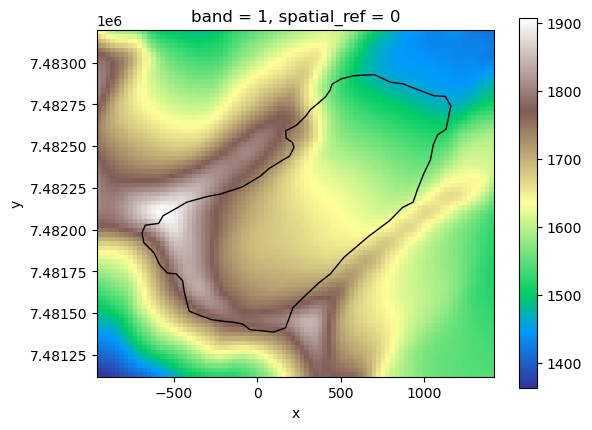

In [10]:
da = rioxarray.open_rasterio(dem_path)
f, ax = plt.subplots()
da.plot(cmap='terrain', ax=ax);
# Add the outlines
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

In order to get the topographical features for our machine learning models, we now make use of the entity task that we declared previously. In order to run this more efficiently, we parallelize this using the function as an entity task in OGGM. The topographical data is already available in the Hub. Since this is computationally expensive, only uncomment the code and run it again if you need to re-run it for any reason. 

In [11]:
topo_dicts = workflow.execute_entity_task(get_topo_predictors, gdirs)

2023-04-16 13:54:22: oggm.workflow: Execute entity tasks [get_topo_predictors] on 3417 glaciers


In [12]:
## Uncomment if you want to update the topo data
# topo_df = pd.DataFrame(topo_dicts)
# topo_df.index = topo_df.ID
# topo_df.index.name = 'RGI_ID'
# topo_df.drop(columns='ID')

In [13]:
# topo_df.to_csv('topo_df.csv')

To avoid computing all topographical predictors each time, just load the previously stored file. This function provides us with all the necessary topographical data for each glacier in Scandinavia:
- `zmed`: Median altitude
- `zmax`: Maximum altitude
- `area`: Area of the glacier in the RGI (ca 2003)
- `slope`: Average slope of the glacier (in degrees)
- `lat`: Latitude (in degrees)
- `icecap`: If the glacier is an icecap or a valley glacier

In [14]:
topo_df = pd.read_csv('Data/topo_df.csv')
topo_df

,RGI_ID,zmed,zmax,zmin,area,slope,lat,icecap,ID
0,RGI60-08.00001,242.0,250.0,235.0,0.030,5.8,67.930,0,RGI60-08.00001
1,RGI60-08.00002,239.0,246.0,228.0,0.030,5.7,67.870,0,RGI60-08.00002
2,RGI60-08.00003,726.0,749.0,701.0,0.020,18.8,67.820,0,RGI60-08.00003
3,RGI60-08.00004,696.0,725.0,671.0,0.020,20.1,67.830,0,RGI60-08.00004
4,RGI60-08.00005,1268.0,1807.0,926.0,21.469,8.5,67.139,0,RGI60-08.00005
...,...,...,...,...,...,...,...,...,...
3412,RGI60-08.03413,980.0,1182.0,887.0,0.098,38.6,68.164,0,RGI60-08.03413
3413,RGI60-08.03414,1377.0,1452.0,1181.0,0.389,17.6,66.590,0,RGI60-08.03414
3414,RGI60-08.03415,1314.0,1330.0,1289.0,0.056,10.7,66.729,0,RGI60-08.03415
3415,RGI60-08.03416,1581.0,1811.0,890.0,14.152,7.7,66.006,0,RGI60-08.03416


## 1. 3. Get glacier climate data

Finally, we need climate data as input features of our models. We get the climate data from CRU for each glacier. Same as for the topographical data, only uncomment the cell underneath if you really need to re-compute the data for a specific reason. 

In [16]:
#global_tasks.compile_climate_input(gdirs)

We just load the previously computed file using xarray, directly available. 

In [15]:
climate_ds = xr.open_dataset('Data/climate_input.nc')
climate_ds

<xarray.Dataset>
Dimensions:         (time: 1416, rgi_id: 3417)
Coordinates:
  * time            (time) float64 1.902e+03 1.902e+03 ... 2.02e+03 2.02e+03
  * rgi_id          (rgi_id) object 'RGI60-08.00001' ... 'RGI60-08.03417'
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
Data variables:
    temp            (time, rgi_id) float32 ...
    prcp            (time, rgi_id) float32 ...
    ref_hgt         (rgi_id) float64 ...
    ref_pix_lon     (rgi_id) float64 ...
    ref_pix_lat     (rgi_id) float64 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.5.3
    calendar:       365-day no leap
    creation_date:  2022-06-24 13:19:30

This xarray `Dataset` provides us with temperature and precipitation for each glacier in the region. 

Let's add the median glacier altitude to the xarray `Dataset` in order to compute a temperature lapse rate.

In [16]:
climate_ds['zmed'] = ('rgi_id', topo_df['zmed'])

The compiled climate dataset has time coordinates in decimal years, which is useless. Let's convert them to `datetime`. For this, we create a custom function to do that. 

In [17]:
def decimal_to_datetime(ds):
    datetimes = []
    for dec_year in ds.time.data:
        year = int(dec_year)
        rem = dec_year - year

        base = datetime(year, 1, 1)
        calendar_time = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
        datetimes.append(calendar_time)
        
    climate_ds['time'] = datetimes
        
    return climate_ds

We trim the data for the desired period.

In [18]:
climate_ds = climate_ds.sel(time=slice(2000.0,2020.0)) 

Let's convert decimal years to `datetime`. As previously done, this is computationally expensive, so only uncomment this if you need to re-run it for a specific reason. The xarray Dataset `climate_ds` that you have loaded already has all this processing in place. 

In [19]:
#climate_ds = decimal_to_datetime(climate_ds)

The final step is to convert the dataset into a DataFrame in order to have a data science ready format.

First we export the dataset as is, which gives as monthly data:

In [20]:
mon_climate_df = climate_ds.to_dataframe()

In [21]:
# mon_climate_df.reset_index(level='year', drop=True, inplace=True)

In [22]:
#mon_climate_df.set_index('hydro_year', append=True)

Then, we resample everything with an annual timestep in order to have annual variables to be included in the ML training dataset. Moreover, we also apply the lapse rates to roughly downscale temperature and the rain/snow fraction at each glacier. For this, we also create a custom function to perform this task.

In [23]:
def get_annual_dataset(climate_ds, period=np.arange(2000.0, 2020.0)):
    """
    Mandatory docstring
    """    
    # Temperature
    climate_ds.temp.data = climate_ds.temp.data + 6.0/1000.0*(climate_ds.zmed.data - climate_ds.ref_hgt.data) # Super rough temperature lapse rate  
    yr_temp_ds = climate_ds.temp.where(climate_ds.temp > 0.0).groupby('hydro_year').sum()
    yr_temp_ds = yr_temp_ds.rename('PDD')
    
    # Snowfall
    yr_snow_ds = climate_ds.prcp.where(climate_ds.temp <= 0.0).groupby('hydro_year').sum()
    yr_snow_ds = yr_snow_ds.rename('snow')
    # Rainfall
    yr_rain_ds = climate_ds.prcp.where(climate_ds.temp > 0.0).groupby('hydro_year').sum()
    yr_rain_ds = yr_rain_ds.rename('rain')
    
    return yr_temp_ds, yr_snow_ds, yr_rain_ds

In [24]:
yr_temp_ds, yr_snow_ds, yr_rain_ds = get_annual_dataset(climate_ds)

And we finally export the 3 annual datasets as `Dataframes.yr_temp_ds`

In [25]:
yr_temp_df = yr_temp_ds.to_dataframe()
yr_snow_df = yr_snow_ds.to_dataframe()
yr_rain_df = yr_rain_ds.to_dataframe()

## 1.4. Creating the ML dataset

Now we need a function that fetches the raw data from these different Dataframes and produces the right list of predictors for the ML models.

The ML models will take predictors for a given hydrological year comprising:

Climate data:

- Annual cumulative snowfall
- Annual cumulative rainfall
- Annual cumulative PDDs
- Monthly average temperature
- Monthly snowfall

Topographical data (around 2003):

- Median glacier altitude
- Maximum glacier altitude
- Minimum glacier altitude
- Glacier area
- Glacier average slope

To be added in order to better constrain ice dynamics (not yet available):

- Average ice thickness


We start by merging the yearly climate Dataframes.

In [26]:
yr_climate_df = pd.concat([yr_temp_df, yr_snow_df, yr_rain_df], axis=1)
yr_climate_df

PDD        snow        rain
hydro_year rgi_id                                           
2000       RGI60-08.00001  40.322890  295.120697  372.512909
           RGI60-08.00002  45.640445  295.188782  373.351196
           RGI60-08.00003  35.414001  338.535095  399.014038
           RGI60-08.00004  34.334001  338.535095  399.014038
           RGI60-08.00005  37.163999  522.478821  538.000427
...                              ...         ...         ...
2019       RGI60-08.03413  60.530295  543.243530  655.152649
           RGI60-08.03414  42.606446  659.431519  610.665527
           RGI60-08.03415  32.761335  758.787720  584.368164
           RGI60-08.03416  68.155333  761.559143  951.634644
           RGI60-08.03417  54.643332  727.541016  903.703247

[68340 rows x 3 columns]

We now need to reformat the dataset in order to have each monthly climate series as a dedicated column. This is some funky `DataFrame` formatting using Pandas. 

In [27]:
def sel_month(df, idx):
    '''
    It takes groupby object and selects one single element of the group, creating a pandas data frames 
    just with that element.
    '''
    df_ = pd.DataFrame(df.groupby(['rgi_id', 'hydro_year'], as_index=False).nth(idx)).reset_index()
    # Check we have the rigth hydromonth
    assert np.unique(df_.hydro_month) == np.array([idx+1])

    df_ = df_.set_index(['rgi_id', 'hydro_year'])
    df_ = df_[['temp', 'prcp']]
    #display(df_)
    col_id = '0'+str(idx+1) if idx < 9 else str(idx+1)
    df_ = df_.rename(columns={'temp': 'temp_'+col_id,
                              'prcp': 'prcp_'+col_id})
    
    return df_

We first sort the dataframe to be sure is in increasing hydro year/month

In [28]:
mon_climate_df = mon_climate_df.sort_values(['rgi_id', 'hydro_year', 'hydro_month'], ascending=True)

Combine information of temperature and precipitation 

In [29]:
mon_training_df = pd.concat([sel_month(mon_climate_df, i) for i in range(12)], axis=1, ignore_index=False)
mon_training_df

temp_01     prcp_01   temp_02     prcp_02   
rgi_id         hydro_year                                               
RGI60-08.00001 2000        2.011111   89.949440 -4.847777   39.799580  \
               2001        3.411111   50.515018 -3.147778   43.414459   
               2002       -0.488889   59.345169 -7.447778   29.263451   
               2003       -2.455556   48.070133 -9.747778   34.243984   
               2004        0.311111   78.174042 -3.414444   31.993261   
...                             ...         ...       ...         ...   
RGI60-08.03417 2015        1.494445  104.149033 -3.284444  111.409660   
               2016        1.894444  217.098801 -1.984444  211.801880   
               2017        1.027778   89.045914 -4.484444  149.197235   
               2018        1.494445  176.113358 -4.384444  158.276733   
               2019        0.694444  217.587555 -1.051111  137.044174   

                             temp_03     prcp_03    temp_04     prcp_04   
rgi_id         hydro_year                                                 
RGI60-08.00001 2000       -10.641112   51.759113 -11.143332   50.980053  \
               2001        -9.341112   49.670944  -7.543333   27.386324   
               2002       -12.507779   24.280972 -12.309999   44.494129   
               2003       -13.707779   27.780344 -17.709999   46.093716   
               2004        -8.741112   62.266918 -10.909999   28.106590   
...                              ...         ...        ...         ...   
RGI60-08.03417 2015        -5.712222  266.413971  -7.793335  155.734222   
               2016        -3.912222  242.586319 -10.393335  101.253311   
               2017        -3.812222  371.887756  -5.493335  299.347626   
               2018        -6.412222  192.674561  -8.093335   64.232956   
               2019        -4.612222  171.008667  -8.993335  167.764053   

                             temp_05     prcp_05    temp_06     prcp_06   
rgi_id         hydro_year                                                 
RGI60-08.00001 2000       -10.580002   29.002270  -6.611111   59.659908  \
               2001       -15.480002   35.375156 -12.011110   28.706146   
               2002       -10.313335   44.540123  -8.044444   37.876644   
               2003        -9.480001   26.073019  -5.611111   28.461843   
               2004       -12.780002   40.665600  -7.111110   24.079779   
...                              ...         ...        ...         ...   
RGI60-08.03417 2015        -4.908890  189.870132  -2.700000   95.728027   
               2016        -6.008890  108.876656  -3.799999  145.192505   
               2017        -6.708890  121.731079  -5.200000  139.568573   
               2018        -9.608891   24.806946  -8.999999   93.973999   
               2019        -6.508890  227.375122  -6.400000  161.393158   

                            temp_07     prcp_07   temp_08    prcp_08   
rgi_id         hydro_year                                              
RGI60-08.00001 2000       -1.732222   63.919777  3.233333  43.892872  \
               2001       -1.865555   43.481659  1.533333  37.501221   
               2002       -0.898889   24.116472  3.333333  40.426228   
               2003       -3.232222   17.521786  4.133333  72.449425   
               2004       -2.298889   28.318407  3.033333  55.463512   
...                             ...         ...       ...        ...   
RGI60-08.03417 2015       -1.488889  118.604233  2.322222  73.268768   
               2016       -1.455556   58.738297  4.088889  61.192421   
               2017       -2.988889  149.403473  1.355556  55.090389   
               2018       -1.488889   65.463066  5.588889  72.653397   
               2019        0.211111   49.349823  2.022222  85.042221   

                             temp_09     prcp_09    temp_10     prcp_10   
rgi_id         hydro_year                                                 
RGI60-08.00001 2000         9.202221   

And merge the monthly dataset with the annual climate dataset

In [30]:
training_df = pd.merge(mon_training_df, yr_climate_df, on=["rgi_id", "hydro_year"])
training_df

temp_01     prcp_01   temp_02     prcp_02   
rgi_id         hydro_year                                               
RGI60-08.00001 2000        2.011111   89.949440 -4.847777   39.799580  \
               2001        3.411111   50.515018 -3.147778   43.414459   
               2002       -0.488889   59.345169 -7.447778   29.263451   
               2003       -2.455556   48.070133 -9.747778   34.243984   
               2004        0.311111   78.174042 -3.414444   31.993261   
...                             ...         ...       ...         ...   
RGI60-08.03417 2015        1.494445  104.149033 -3.284444  111.409660   
               2016        1.894444  217.098801 -1.984444  211.801880   
               2017        1.027778   89.045914 -4.484444  149.197235   
               2018        1.494445  176.113358 -4.384444  158.276733   
               2019        0.694444  217.587555 -1.051111  137.044174   

                             temp_03     prcp_03    temp_04     prcp_04   
rgi_id         hydro_year                                                 
RGI60-08.00001 2000       -10.641112   51.759113 -11.143332   50.980053  \
               2001        -9.341112   49.670944  -7.543333   27.386324   
               2002       -12.507779   24.280972 -12.309999   44.494129   
               2003       -13.707779   27.780344 -17.709999   46.093716   
               2004        -8.741112   62.266918 -10.909999   28.106590   
...                              ...         ...        ...         ...   
RGI60-08.03417 2015        -5.712222  266.413971  -7.793335  155.734222   
               2016        -3.912222  242.586319 -10.393335  101.253311   
               2017        -3.812222  371.887756  -5.493335  299.347626   
               2018        -6.412222  192.674561  -8.093335   64.232956   
               2019        -4.612222  171.008667  -8.993335  167.764053   

                             temp_05     prcp_05    temp_06     prcp_06   
rgi_id         hydro_year                                                 
RGI60-08.00001 2000       -10.580002   29.002270  -6.611111   59.659908  \
               2001       -15.480002   35.375156 -12.011110   28.706146   
               2002       -10.313335   44.540123  -8.044444   37.876644   
               2003        -9.480001   26.073019  -5.611111   28.461843   
               2004       -12.780002   40.665600  -7.111110   24.079779   
...                              ...         ...        ...         ...   
RGI60-08.03417 2015        -4.908890  189.870132  -2.700000   95.728027   
               2016        -6.008890  108.876656  -3.799999  145.192505   
               2017        -6.708890  121.731079  -5.200000  139.568573   
               2018        -9.608891   24.806946  -8.999999   93.973999   
               2019        -6.508890  227.375122  -6.400000  161.393158   

                            temp_07     prcp_07   temp_08    prcp_08   
rgi_id         hydro_year                                              
RGI60-08.00001 2000       -1.732222   63.919777  3.233333  43.892872  \
               2001       -1.865555   43.481659  1.533333  37.501221   
               2002       -0.898889   24.116472  3.333333  40.426228   
               2003       -3.232222   17.521786  4.133333  72.449425   
               2004       -2.298889   28.318407  3.033333  55.463512   
...                             ...         ...       ...        ...   
RGI60-08.03417 2015       -1.488889  118.604233  2.322222  73.268768   
               2016       -1.455556   58.738297  4.088889  61.192421   
               2017       -2.988889  149.403473  1.355556  55.090389   
               2018       -1.488889   65.463066  5.588889  72.653397   
               2019        0.211111   49.349823  2.022222  85.042221   

                             temp_09     prcp_09    temp_10     prcp_10   
rgi_id         hydro_year                                                 
RGI60-08.00001 2000         9.202221   

And we finally add the topographical data


In [31]:
training_df = training_df.reset_index().merge(topo_df.set_index('ID'), how='left', left_on='rgi_id', right_index=True)
training_df = training_df.set_index(['rgi_id', 'hydro_year'])
training_df = training_df.reindex(sorted(training_df.columns), axis=1)
training_df

PDD          RGI_ID  area  icecap     lat   
rgi_id         hydro_year                                                    
RGI60-08.00001 2000        40.322890  RGI60-08.00001  0.03       0  67.930  \
               2001        42.489556  RGI60-08.00001  0.03       0  67.930   
               2002        38.044445  RGI60-08.00001  0.03       0  67.930   
               2003        39.844445  RGI60-08.00001  0.03       0  67.930   
               2004        40.577779  RGI60-08.00001  0.03       0  67.930   
...                              ...             ...   ...     ...     ...   
RGI60-08.03417 2015        51.437776  RGI60-08.03417  0.15       0  65.923   
               2016        55.643333  RGI60-08.03417  0.15       0  65.923   
               2017        50.003331  RGI60-08.03417  0.15       0  65.923   
               2018        57.004444  RGI60-08.03417  0.15       0  65.923   
               2019        54.643332  RGI60-08.03417  0.15       0  65.923   

                              prcp_01     prcp_02     prcp_03     prcp_04   
rgi_id         hydro_year                                                   
RGI60-08.00001 2000         89.949440   39.799580   51.759113   50.980053  \
               2001         50.515018   43.414459   49.670944   27.386324   
               2002         59.345169   29.263451   24.280972   44.494129   
               2003         48.070133   34.243984   27.780344   46.093716   
               2004         78.174042   31.993261   62.266918   28.106590   
...                               ...         ...         ...         ...   
RGI60-08.03417 2015        104.149033  111.409660  266.413971  155.734222   
               2016        217.098801  211.801880  242.586319  101.253311   
               2017         89.045914  149.197235  371.887756  299.347626   
               2018        176.113358  158.276733  192.674561   64.232956   
               2019        217.587555  137.044174  171.008667  167.764053   

                              prcp_05     prcp_06     prcp_07    prcp_08   
rgi_id         hydro_year                                                  
RGI60-08.00001 2000         29.002270   59.659908   63.919777  43.892872  \
               2001         35.375156   28.706146   43.481659  37.501221   
               2002         44.540123   37.876644   24.116472  40.426228   
               2003         26.073019   28.461843   17.521786  72.449425   
               2004         40.665600   24.079779   28.318407  55.463512   
...                               ...         ...         ...        ...   
RGI60-08.03417 2015        189.870132   95.728027  118.604233  73.268768   
               2016        108.876656  145.192505   58.738297  61.192421   
               2017        121.731079  139.568573  149.403473  55.090389   
               2018         24.806946   93.973999   65.463066  72.653397   
               2019        227.375122  161.393158   49.349823  85.042221   

                              prcp_09     prcp_10     prcp_11     prcp_12   
rgi_id         hydro_year                                                   
RGI60-08.00001 2000         82.060509   58.451614   50.218761   47.939716  \
               2001         21.494608   83.403297   62.819103   35.580780   
               2002         53.544838  103.911064   55.259472   67.236656   
               2003         23.149651   58.197781   80.069733   48.463291   
               2004         57.078709   57.060844   97.000999  105.222382   
...                               ...         ...         ...         ...   
RGI60-08.03417 2015         99.347084   90.682648   88.481743  135.403824   
               2016         74.471062   70.880188  119.976753  147.315826   
               2017         67.357719  117.627174  156.433319   33.727993   
               2018        123.401054   25.543489  177.151459  250.382614   
               2019        145.225189   47.727448   84.718292  137.008652   

                         

We save the training DataFrame with all the necessary training data to be used in the following notebooks.

In [32]:
training_df.to_csv('Data/training_df.csv')